# Table Of Contents

Representations learned from Contrastive Learning before Supervised Fine-Tuning

Click to Skip to Histograms Aggregating the Following Attributes:

* [Scene](#Scene-Counts-Per-Cluster)
* [Action](#Action-Class-Counts-Per-Cluster)
* [Person ID](#Person-ID-Counts-Per-Cluster)


In [117]:
import os
import numpy as np

with open('experiments.txt', 'r') as f:
    experiments=[line.split('\n')[0] for line in f]
len(experiments)

253

In [2]:
### PARAMS ####
contrastive = True
pre_fine_tuning = True

In [3]:
import torch
# load models
from models import video_resnet, contrastive_model

def _init_backbone(num_classes):
    model = video_resnet.r3d_18(num_classes=num_classes, endpoint='fc', positional_flag = 1)
    return model

def build_mlp(in_features, repr_size):
    import torch.nn as nn
    hidden = nn.Linear(in_features=in_features, out_features=in_features)
    output_layer = nn.Linear(in_features=in_features, out_features=repr_size)

    return nn.Sequential(hidden, nn.ReLU(), output_layer)

if contrastive:
    base_model = contrastive_model.ContrastiveModel(_init_backbone, repr_size=128, visualizations=pre_fine_tuning)
    #exp_name = 'cv_same_timepoint_eval_single_clip_100contrastive_endpoint_A_finetune_TrueFalse'
    exp_name = 'cross_view_contrastive_same_timepointresnet3D1832128_False_clips_1_lr_0.02augmentFalse'
    if not pre_fine_tuning:
        base_model.eval_finetune(finetune=True, endpoint='A', num_classes=60)

else:
    base_model = video_resnet.r3d_18(endpoint='fc', positional_flag = 1)
    exp_name = 'supervised_CV_10resnet3D181616_False_clips_1_gru_False_CS_False'
loaded_model = torch.load(f'./results/{exp_name}/model_best.pth.tar')
if not contrastive and not pre_fine_tuning:
    print(loaded_model['best_acc'])
base_model.load_state_dict(loaded_model['state_dict'])

<All keys matched successfully>

In [4]:
### PARAMS FOR VISUALIZATION ###
view_only_viz = False
number_samples = 50
num_limited_targets = 20

In [5]:
from torchvision import transforms
import pickle
from Data.spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from Data.NTUARD_Dataset_Train import NTUARD_TRAIN

# old getter
def get_ntuard(root='Data', frames_path='/datasets/NTU-ARD/frames-240x135', num_clips=1, cross_subject=False, norm=True):

    normal_mean = (0.5, 0.5, 0.5)
    normal_std = (0.5, 0.5, 0.5)
    
    ## augmentations
    crop_scales = [1.0]
    for _ in range(1, 5):
        crop_scales.append(crop_scales[-1] * 0.84089641525)  ##smallest scale is 0.5

    transformations = [Scale(136), CenterCrop(112), ToTensor(1)]
    #transformations = [ToTensor(1)]

    if norm:
        transformations.append(transforms.Normalize(mean=normal_mean, std=normal_std))
    transform_train = Compose(transformations)

    transform_val = Compose(transformations)

    train_dataset = NTUARD_TRAIN(root=root, train=True, fold=1, cross_subject=cross_subject, transform=transform_train,
                                 num_clips=num_clips, frames_path=frames_path, args=None, pseudo_label=False)
    test_dataset = NTUARD_TRAIN(root=root, train=False, fold=1, cross_subject=cross_subject, transform=transform_val, num_clips=num_clips, frames_path=frames_path, args=None)

    return train_dataset, test_dataset

# get data
train_dataset, test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False)

In [6]:
itemize_index_by_target = {i:[] for i in range(1,61)}

for i, target in enumerate(test_dataset.targets):
    if target <= num_limited_targets:
        itemize_index_by_target[target].append(i)

# T-SNE Visualizations 

In [7]:
import numpy as np
sampled_targets = []
for indicies in itemize_index_by_target.values():
    if len(indicies) > 0:
        sampled_targets.extend(np.random.choice(indicies, number_samples))

In [77]:
import psutil

class NTUARD_MetaData:
    def __init__(self, scene, action, pid, rid, view):
        self.scene=scene
        self.action=action
        self.pid=pid
        self.rid=rid
        self.view=view

base_model.fc = None
base_model.eval_mode = None
base_model.cuda()
representations = []
respective_targets = []
meta_data = []

base_model.eval()
for counter, i in enumerate(sampled_targets):
    data, target = test_dataset.__getitem__(i)
    other_metadata, view = test_dataset.video_paths[i]['path'].split("/")[-2:]
    scene, pid, rid, action = test_dataset._decrypt_vid_name(other_metadata)
    meta_data.append(NTUARD_MetaData(scene, action, pid, rid, int(view)))
    respective_targets.append(target)
    with torch.no_grad():
        representations.append(base_model(data.cuda()).squeeze().cpu().numpy())        

In [78]:
representations = np.array(representations)

In [79]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import numpy as np

seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#pca = PCA(n_components=50)
#pca_result = pca.fit_transform(representations)

#TSNE(2)
representations.shape

(1000, 128)

In [80]:
#print(pca_result.shape)
tsne = TSNE(n_components=2).fit_transform(representations)


In [81]:
# SOURCE: https://learnopencv.com/t-sne-for-feature-visualization/
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


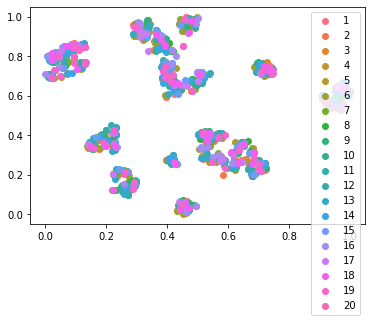

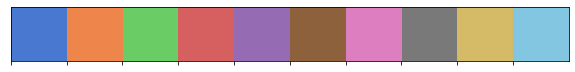

In [135]:
# SOURCE: https://learnopencv.com/t-sne-for-feature-visualization/
import warnings
warnings.filterwarnings( "ignore", module = "color\..*" )

fig = plt.figure()
ax = fig.add_subplot(111)
sns.palplot(sns.color_palette("muted"))
rgb_values = sns.color_palette("husl", num_limited_targets)
colors_per_class = dict(zip(list(range(1,num_limited_targets+1)), rgb_values))
# for every class, we'll add a scatter plot separately
idx = 0
for label in colors_per_class:
    if idx == num_limited_targets:
        break
    else:
        idx+=1
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(respective_targets) if l == label]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    # convert the class color to matplotlib format
    color = colors_per_class[label]
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, color=color, label=label)

# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()

# Clustering the representations and Meta Data Histograms

In [109]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=13, random_state=1).fit(tsne)
labels = kmeans_model.labels_

len(labels)

1000

In [110]:
len(meta_data)

1000

In [112]:
#histogram
def get_subset_arr(arr, label, d):
    indicies = d[label]
    return [arr[i] for i in indicies]

indicies_per_cluster_label = {l:[] for l in set(labels)}
for i, label in enumerate(labels):
    indicies_per_cluster_label[label].append(i)


## Scene Counts Per Cluster

Cluster 0


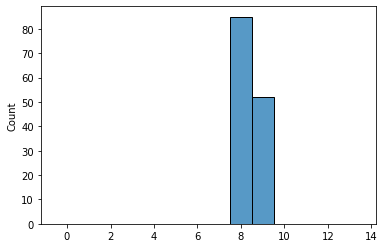

Cluster 1


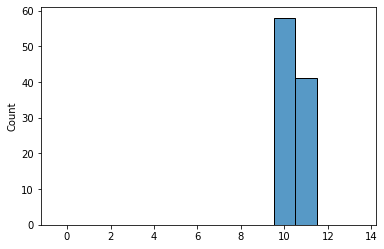

Cluster 2


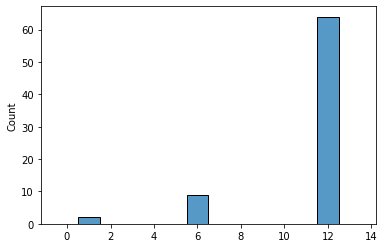

Cluster 3


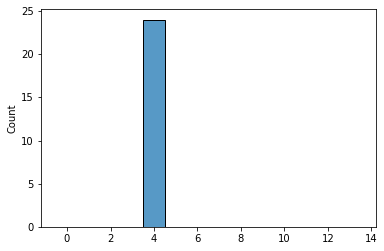

Cluster 4


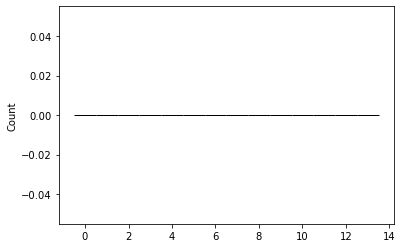

Cluster 5


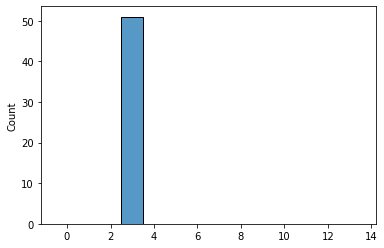

Cluster 6


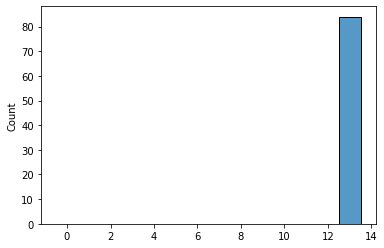

Cluster 7


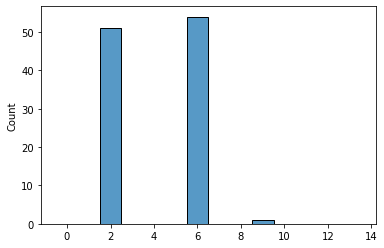

Cluster 8


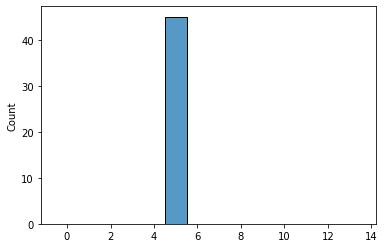

Cluster 9


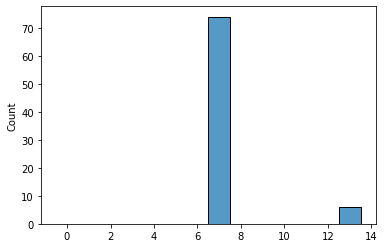

Cluster 10


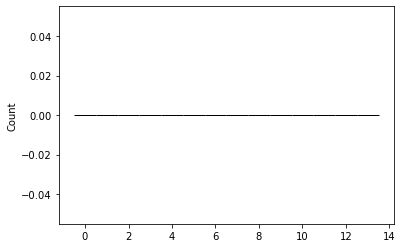

Cluster 11


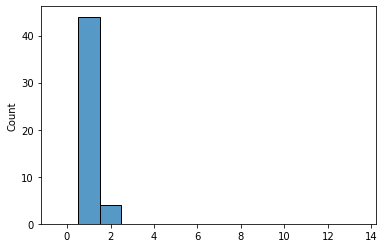

Cluster 12


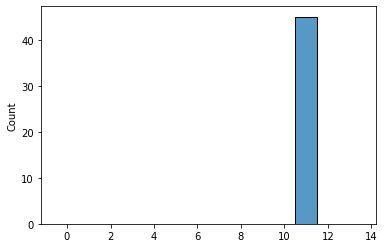

In [113]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.scene for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


## Action Class Counts Per Cluster

Cluster 0


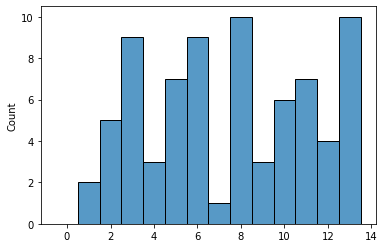

Cluster 1


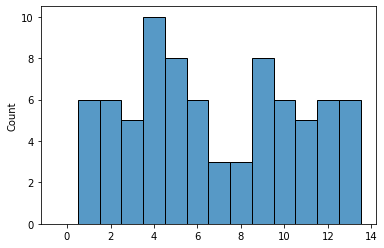

Cluster 2


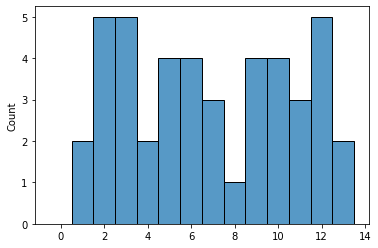

Cluster 3


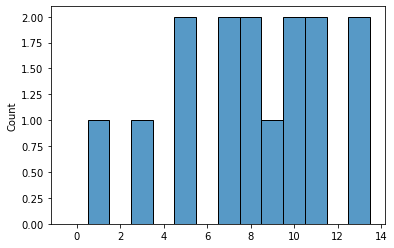

Cluster 4


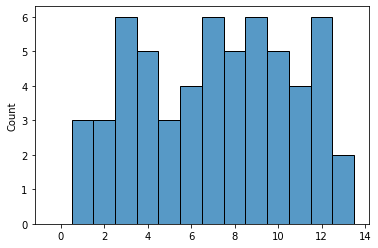

Cluster 5


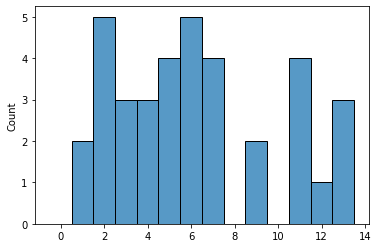

Cluster 6


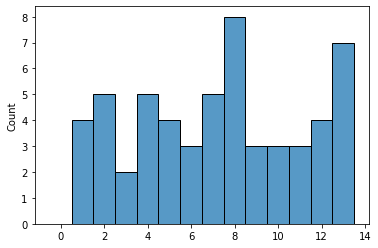

Cluster 7


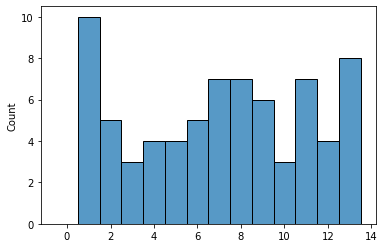

Cluster 8


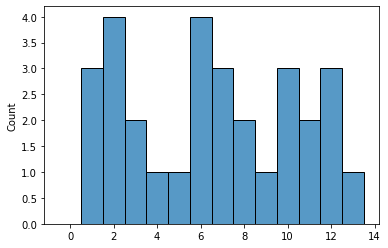

Cluster 9


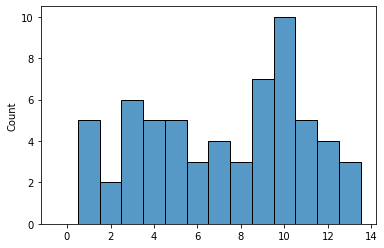

Cluster 10


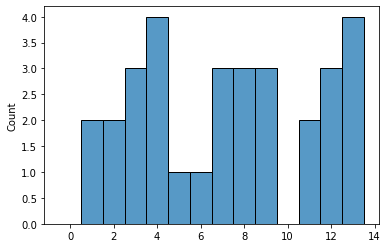

Cluster 11


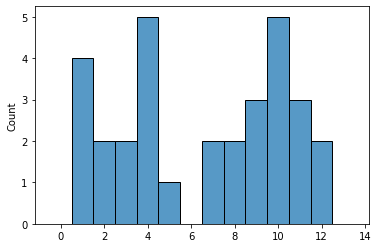

Cluster 12


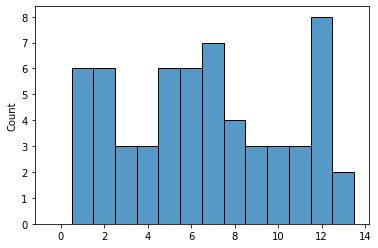

In [114]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.action for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


## Person ID Counts Per Cluster

Cluster 0


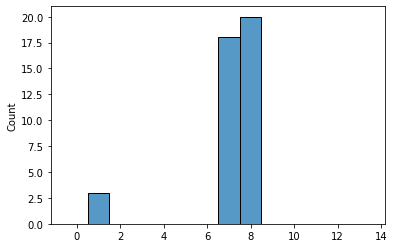

Cluster 1


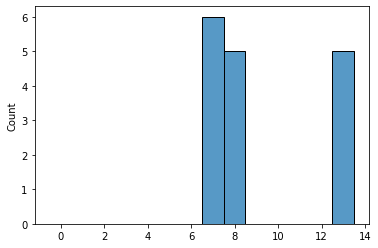

Cluster 2


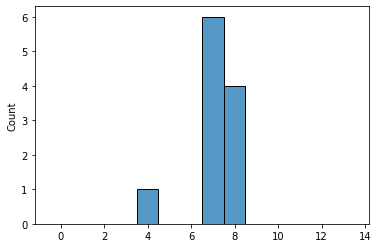

Cluster 3


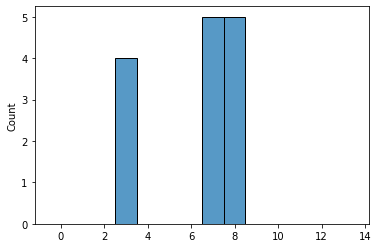

Cluster 4


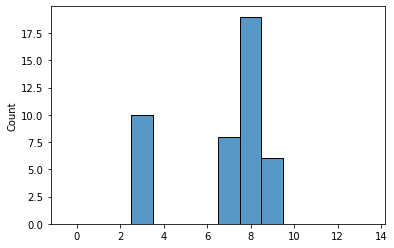

Cluster 5


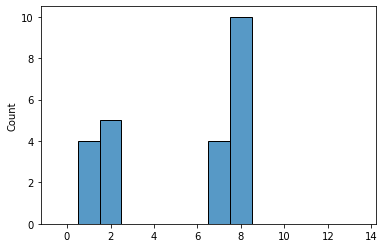

Cluster 6


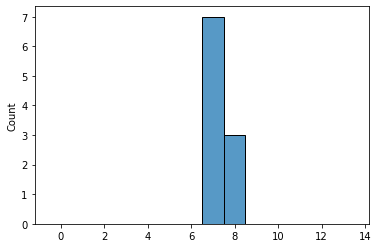

Cluster 7


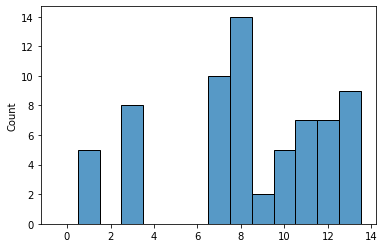

Cluster 8


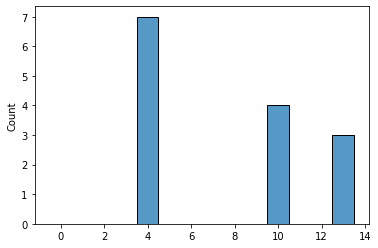

Cluster 9


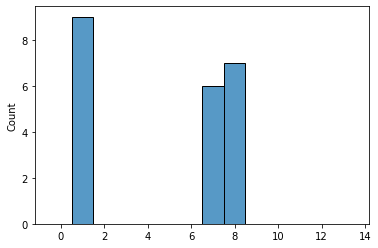

Cluster 10


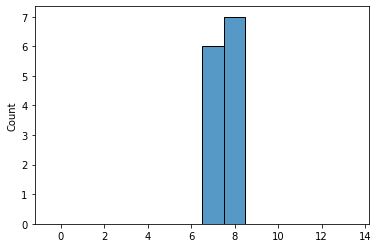

Cluster 11


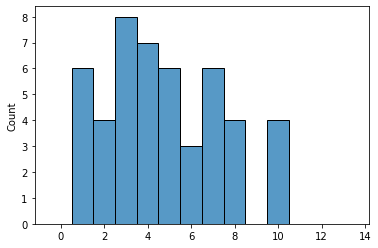

Cluster 12


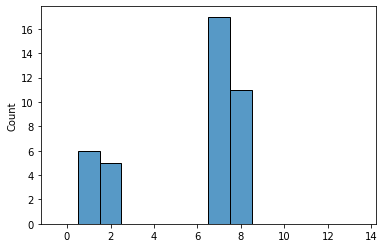

In [116]:
for cluster_label in indicies_per_cluster_label.keys():
    print("Cluster", cluster_label)
    sns.histplot([m.pid for i, m in \
                  enumerate(get_subset_arr(meta_data, cluster_label, \
                                           indicies_per_cluster_label))] , discrete=1, stat="count", binrange=(0,13))
    plt.show()


# Grad Cam

In [82]:
!pip install grad-cam
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install ttach

In [109]:
def visualize_grad_cam(data, heatmap):
    # one off alignment (skip last frame, or copy)
    chosen_channel = 0
    i_num, x_num, y_num = heatmap.shape
    for i in range(i_num):
        for x in range(x_num):
            for y in range(y_num):
                data[i, x, y, chosen_channel] = heatmap[i, x, y]
    return data

In [112]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision.models.video import r3d_18
import mediapy as media
import numpy as np
import einops

target_viz = 9
_, viz_test_dataset = get_ntuard('Data', num_clips=1, cross_subject=False, norm=False)
num_incorrect = 0
for idx in range(len(itemize_index_by_target[target_viz])):
    i = itemize_index_by_target[target_viz][idx]
    data, target = viz_test_dataset.__getitem__(i)

    base_model.eval()
    prediction = torch.argmax(base_model(input_tensor.cuda())) + 1
    print("Predicted", prediction)
    
    if target_viz == prediction.item():

        data = einops.rearrange(data, 'b c f h w -> (b f) h w c')
        data = data.cpu().numpy()
        data = data.astype(np.uint8)

        media.show_video(data, fps=2) 

        target_layer = model.layer4[-1]
        input_tensor, _ = test_dataset.__getitem__(i)
        input_tensor = einops.rearrange(input_tensor, 'b c f h w -> b c f h w')
        # Create an input tensor image for your model..
        # Note: input_tensor can be a batch tensor with several images!

        # Construct the CAM object once, and then re-use it on many images:
        if contrastive:
            target_layer = base_model.base_model.layer4
        else:
            target_layer = base_model.layer4

        cam = GradCAM(model=base_model, target_layer=target_layer, use_cuda=True)

        # If target_category is None, the highest scoring category
        # will be used for every image in the batch.
        # target_category can also be an integer, or a list of different integers
        # for every image in the batch.
        target_category = target_viz
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

        # In this example grayscale_cam has only one image in the batch:
        #grayscale_cam = grayscale_cam[0, :]
        #visualization = show_cam_on_image(data, grayscale_cam)


        grayscale_cam=(grayscale_cam*255).astype(np.uint8).reshape(112,112,7)
        grayscale_cam = einops.rearrange(grayscale_cam, 'h w f -> f h w')
        media.show_video(grayscale_cam, fps=2) 
        media.show_video(visualize_grad_cam(data, grayscale_cam), fps=2)
        continue
    else:
        print(target_viz, prediction)
        num_incorrect+=1
print("Percent incorrect, ", num_incorrect/len(itemize_index_by_target[target_viz]))

torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8,

Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, 

Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, 

torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8, 112, 112])
Predicted tensor(1, device='cuda:0')
9 tensor(1, device='cuda:0')
torch.Size([1, 3, 8,